In [58]:
import os
import glob
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import math
import scipy.misc
from tqdm import tqdm

# we need to know original resolution, so img_path should be a location of original files
# benchmark image path may already cropped.
IMAGE_SRC_DIR = '/mnt/data_export/images/'
annot_path = '/home/phantom/projects/vision/phantomnet/datasets/phantom/Annotations'

seg_bench_root = '/media/phantom/World/phantom_benchmark'
out_gt_path = os.path.join(seg_bench_root, 'detection', 'gt.txt')
img_path = os.path.join(seg_bench_root, 'images')
imgfs = glob.glob(os.path.join(img_path, '*.png'))        # test set list

# print('Building file locator..')
# file_locator = {}
# for root, dirs, files in os.walk(IMAGE_SRC_DIR):
#     for file in files:
#         if file[0] == '.': continue
#         file_locator[file] = os.path.join(root, file)

We need to change labels, because we only use `vehicle`, `cyclist`, `person`, `lane`, `road`. (For detection, only `vehicle` ~ `person`.)

In [59]:
# Here we adjust labels
label_map = {
    'none': (0, 'background'),
    'sedan': (1, 'vehicle'),
    'sedan-occluded': (1, 'vehicle'),
    'suv': (1, 'vehicle'),
    'suv-occluded': (1, 'vehicle'),
    'truck': (1, 'vehicle'),
    'truck-occluded': (1, 'vehicle'),
    'caravan': (1, 'vehicle'),
    'caravan-occluded': (1, 'vehicle'),
    'trailer': (1, 'vehicle'),
    'trailer-occluded': (1, 'vehicle'),
    'bus': (1, 'vehicle'),
    'bus-occluded': (1, 'vehicle'),
    'lane-dashed': (4, 'lane'),
    'lane-solid': (4, 'lane'),
    'lane-dotted': (4, 'lane'),
    'pedestrian': (3, 'person'),
    'free_space': (5, 'road'),
    'bicyclist': (2, 'cyclist'),
    'bicycle': (2, 'cyclist'),
    'motorcycle': (2, 'cyclist'),
    'motorcyclist': (2, 'cyclist'),
}
label_map = {key: label_map[key][1] for key in label_map}
print(label_map)

{'none': 'background', 'trailer-occluded': 'vehicle', 'lane-dashed': 'lane', 'truck-occluded': 'vehicle', 'suv-occluded': 'vehicle', 'bus-occluded': 'vehicle', 'sedan-occluded': 'vehicle', 'trailer': 'vehicle', 'bus': 'vehicle', 'caravan': 'vehicle', 'truck': 'vehicle', 'free_space': 'road', 'motorcycle': 'cyclist', 'pedestrian': 'person', 'suv': 'vehicle', 'bicyclist': 'cyclist', 'lane-dotted': 'lane', 'caravan-occluded': 'vehicle', 'lane-solid': 'lane', 'sedan': 'vehicle', 'bicycle': 'cyclist', 'motorcyclist': 'cyclist'}


(0.45005787037037026, 0.58827160493827124, 0.50468749999999996, 0.67379972565157698)
(0.53371913580246888, 0.58737997256515739, 0.57538580246913518, 0.65706447187928629)
(0.57785493827160472, 0.59624914266117934, 0.61288580246913527, 0.64444444444444415)
(0.51069878472222185, 0.60485325217192454, 0.53137418016975269, 0.63512445701874676)
(0.5214355468749996, 0.58923611111111085, 0.547607421875, 0.61996527777777743)
(0.65982510288065777, 0.5801554641060811, 0.68101851851851802, 0.59460448102423358)
(0.035590277777777755, 0.60308641975308608, 0.1342013888888888, 0.73209876543209873)
(0.19427083333333331, 0.59320987654320989, 0.28454861111111091, 0.69979423868312729)
(0.079340277777777732, 0.5148148148148145, 0.23246527777777776, 0.69506172839506131)
(0.29965277777777766, 0.60041152263374442, 0.35312500000000002, 0.67283950617283916)
(0.27162724247685172, 0.61471193415637826, 0.31581488715277778, 0.66287294238683103)
(0.24483024691358021, 0.5728395061728393, 0.29390432098765423, 0.6469135

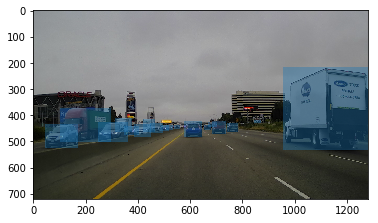

In [76]:
def create_gt(annotation_path, sz):
    with open(annotation_path, 'r') as jsf:
        data = json.load(jsf)

    items = data.get('markResult', [])
    gt = np.zeros(sz, np.uint8)
    
    im_width = float(sz[1])
    im_height = float(sz[0])
    bboxes = []
    labels = []
    
    for item in items:
        if item['type'] == 'Rect':
            label = item['extend']['currentDataKey']
            xs = [v['x'] for v in item['position']]
            ys = [v['y'] for v in item['position']]
            xmin = np.min(xs)
            xmax = np.max(xs)
            ymin = np.min(ys)
            ymax = np.max(ys)
            
            xmin = np.maximum(xmin, 0)
            ymin = np.maximum(ymin, 0)
            xmax = np.minimum(xmax, sz[1])
            ymax = np.minimum(ymax, sz[0])
            
            if xmin>=xmax or ymin>=ymax: continue
                
            #####
            # I do not like this part but .. it is decided.
            # height 720 cropping
            if ymin > 720: continue
            ymax = np.minimum(ymax, 720)
            #####
            
            labels.append(label)
            bboxes.append((xmin / im_width, ymin / im_height, xmax / im_width, ymax / im_height))
    return labels, bboxes

imgf = imgfs[20]
imgf = '/media/phantom/World/phantom_benchmark/images/2017-06-09-07-09-10_test_drive_023_usb_cam_image_raw_00453.png'
name = os.path.splitext(os.path.basename(imgf))[0]
annotf = os.path.join(annot_path, name + '.txt')

img = scipy.misc.imread(imgf)
assert(img.shape[:2] == (720, 1280))
labels, bboxes = create_gt(annotf, sz=img.shape[:2])

import matplotlib.patches as patches
def draw_box(img, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bboxes:
        print(bbox)
        bbox = np.array(bbox)
        bbox[:2] *= [1280, 720]
        bbox[2:] *= [1280, 720]
        w = bbox[2]-bbox[0]
        h = bbox[3]-bbox[1]
        ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), w, h, alpha=0.4))
    plt.show()
    
draw_box(img, bboxes)

In [77]:
with open(out_gt_path, 'w') as fp:
    for imgf in tqdm(imgfs):
        name = os.path.splitext(os.path.basename(imgf))[0]
        annotf = os.path.join(annot_path, name + '.txt')

        img = scipy.misc.imread(imgf)
#         assert(img.shape[:2] == (720, 1280))
        if img.shape[:2] != (720, 1280): import pdb; pdb.set_trace()
        labels, bboxes = create_gt(annotf, sz=img.shape[:2])

        for label, bbx in zip(labels, bboxes):
            fp.write('%s %.3f %.3f %.3f %.3f %s\n' %
                (name, bbx[0], bbx[1], bbx[2], bbx[3], label_map[label.lower()]))

100%|██████████| 6426/6426 [03:13<00:00, 33.19it/s]
